In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Statistical Analysis of Pokemon Showdown - Jacob Hornung - [Website](https://jhornung1.github.io)
At it's very heart, competetive Pokemon is about two things. Risk Management and Statistics. I won't be going into the risk management portion, but for this entire project, I will be taking a deep dive into the many, many different statistics that make up the competetive Pokemon community. This topic is important to anybody who has ever played competetive Pokemon, and is even more important to data science as we will be able to easily explain the process that goes into creating and analyzing a data model (The Data Science LifeCycle).

I have used a lot of different questions over the course of my project, but to finish off my process, I want to end where my love for Pokemon began, with taking an in depth look into Tyranitar. Over the course of this final deliverable, I will be asking and answering the primary question of "What will Tyranitar's usage look in the future?"



---


![Tyranitar](https://sjc1.vultrobjects.com/cucdn/gallery-23/art/pbwv2-tyranitar.jpg)
Tyranitar circa 2001


---


### Basic Information about Smogon
I could very easily spend hours explaining all of the terminology and general information needed to have a basic understanding of competetive Pokemon, but that is all mostly outside of the scope of this assignment. The most important things to know is that Smogon (the competetive Pokemon community) divides all individual Pokemon into tiers, with the main tier being OU (OverUsed), with the next tiers being UU, RU, NU, PU, ZU, and Untiered. The best Pokemon in the game are in OU, with the very worst being in Untiered.

There is also usage rate (the main statistic I will be analyzing), which is how much a Pokemon is used within that tier. A usage percent of 100 means that the Pokemon was brought to every single game. Raw % is the percentage of games the Pokemon was brought to, while Real % is the number of games the Pokemon was actually used in.

Finally, here are a couple links for future reading that should help explain more of the basics of Pokemon:

[Getting Started with Competetive Battling - Smogon](https://www.smogon.com/articles/getting-started)

[Stats Explained - Bulbapedia](https://bulbapedia.bulbagarden.net/wiki/Stat)

# 1. Data Collection
There are two sources that all of my data will be obtained from. This is the [Smogon usage stats resource](https://www.smogon.com/stats/) (which has stats going back to 2014!) and the [Pokemon Database complete Pokedex](https://pokemondb.net/pokedex/all) (which is used to get Pokemon types and stats). First, I read in the Pokemon Database table, using webscraping, then I read in the Smogon stats page for the respective tier and generation that I want to look into.

In [2]:
# Pokemon Database Pokedex

# Have to use custom user agent to bypass 403
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'
}
response = requests.get("https://pokemondb.net/pokedex/all", headers=headers)

# Read HTML table
tables = pd.read_html(response.content)
pokemon_df_table = tables[0]  # Assuming the table is the first one on the page
pokemon_df_table.head()

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,Bulbasaur,Grass Poison,318,45,49,49,65,65,45
1,2,Ivysaur,Grass Poison,405,60,62,63,80,80,60
2,3,Venusaur,Grass Poison,525,80,82,83,100,100,80
3,3,Venusaur Mega Venusaur,Grass Poison,625,80,100,123,122,120,80
4,4,Charmander,Fire,309,39,52,43,60,50,65


In [3]:
# Smogon Stats

P2024_09_ou_1500 = pd.read_csv('https://www.smogon.com/stats/2024-09/gen9ou-1500.txt', delimiter='|', skiprows={0,1,2,4}, skipfooter=1, engine='python')
P2024_09_ou_1500.head()

,,Rank,Pokemon,Usage %,Raw,%,Real,% .1,.1
0,,1,Great Tusk,30.94066%,563847,25.783%,438832,25.652%,
1,,2,Kingambit,22.32297%,417612,19.096%,275574,16.109%,
2,,3,Gholdengo,20.53057%,391079,17.883%,296858,17.353%,
3,,4,Dragapult,17.24182%,361860,16.547%,278739,16.294%,
4,,5,Iron Valiant,16.70787%,311532,14.245%,222736,13.020%,


The Smogon DataFrame is nowhere near cleaned up, but that is a problem for our next step. Which is also the step where we will be combining the two DataFrames into one, and making them nice and pretty (plus making a function that will make it easier to call future DataFrames).

# 2. Data Processing
Our first step in fixing up all of this data, is doing all the fixing for the Pokemon Database dataframe, which is shown below. This first part is correctly splitting the multitypes, and then ordering the columns into a better format.

In [4]:
# First we need to slpit the two types into two tables and drop the old Type column
pokemon_df_table[['Type 1', 'Type 2']] = pokemon_df_table['Type'].str.split(' ', n=1, expand=True)
pokemon_df_table = pokemon_df_table.drop(columns=['Type'])

# We then re-order the columns into a better order
pokemon_df_table = pokemon_df_table[['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]

# Finally we set the Pokedex Number as the index
pokemon_df_table = pokemon_df_table.set_index('#')

# Display the improved DataFrame
pokemon_df_table.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
#,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,None,309,39,52,43,60,50,65


Then we need to fix the names for all of the Pokemon that we can write a function to autochange the names of.

In [5]:
# Function to format Mega Pokemon names
def clean_pokemon_name_mega(name):
    if "Mega" in name:
        parts = name.split("Mega ", 1)
        if len(parts) > 1:
            return parts[1] + "-Mega"
        else:
            return name  # Handle cases where "Mega" might be part of a different word (like Yanmega or Meganium)
    return name

# Function to format Alolan Pokemon Names
def clean_pokemon_name_alolan(name):
    if "Alolan" in name:
        parts = name.split("Alolan ", 1)
        if len(parts) > 1:
            return parts[1] + "-Alola"
    else:
        return name

# Function to format Galarian Pokemon Names
def clean_pokemon_name_galarian(name):
    if "Galarian" in name:
        parts = name.split("Galarian ", 1)
        if len(parts) > 1:
            return parts[1] + "-Galar"
    else:
        return name

# Function to format Hisuian Pokemon Names
def clean_pokemon_name_hisuian(name):
    if "Hisuian" in name:
        parts = name.split("Hisuian ", 1)
        if len(parts) > 1:
            return parts[1] + "-Hisui"
    else:
        return name

# Function to format Paldean Names
def clean_pokemon_name_paldean(name):
    if "Paldean" in name:
        parts = name.split("Paldean ", 1)
        if len(parts) > 1:
            return parts[1] + "-Paldea"
    else:
        return name

# Apply the cleaning function to the 'Pokemon' column
pokemon_df_table['Name'] = pokemon_df_table['Name'].apply(clean_pokemon_name_mega)
pokemon_df_table['Name'] = pokemon_df_table['Name'].apply(clean_pokemon_name_alolan)
pokemon_df_table['Name'] = pokemon_df_table['Name'].apply(clean_pokemon_name_galarian)
pokemon_df_table['Name'] = pokemon_df_table['Name'].apply(clean_pokemon_name_hisuian)
pokemon_df_table['Name'] = pokemon_df_table['Name'].apply(clean_pokemon_name_paldean)

pokemon_df_table.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
#,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,Venusaur-Mega,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,None,309,39,52,43,60,50,65


Finally we need to manually change a lot of the Pokemon's names, because a lot of them are individual and unique (Like Basculin Red Stripe and Tatsugiri Curly Form). Something interesting, is that at some point Gamefreak (the makers of Pokemon) changed the way they spell form. For generations up to gen 7 they spelled it 'forme', but then they switched to spelling it 'form'.

In [6]:
# Simplifying the name because I will be typing it a lot
pdft = pokemon_df_table

# All of the manual changes that needed to be done
pdft['Name'] = pdft['Name'].str.replace(r"Tauros\s+Combat\s+Breed", "Tauros-Paldea-Combat", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Tauros\s+Blaze\s+Breed", "Tauros-Paldea-Blaze", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Tauros\s+Aqua\s+Breed", "Tauros-Paldea-Aqua", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Kyogre\s+Primal\s+Kyogre", "Kyogre-Primal", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Groudon\s+Primal\s+Groudon", "Groudon-Primal", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Deoxys\s+Normal\s+Deoxys", "Deoxys", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Deoxys\s+Attack\s+Deoxys", "Deoxys-Attack", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Deoxys\s+Defense\s+Deoxys", "Deoxys-Defense", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Deoxys\s+Speed\s+Deoxys", "Deoxys-Speed", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Burmy\s+Plant\s+Cloak", "Burmy-Plant", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Burmy\s+Sandy\s+Cloak", "Burmy-Sandy", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Burmy\s+Trash\s+Cloak", "Burmy-Trash", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Wormadam\s+Plant\s+Cloak", "Wormadam-Plant", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Wormadam\s+Sandy\s+Cloak", "Wormadam-Sandy", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Wormadam\s+Trash\s+Cloak", "Wormadam-Trash", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Rotom\s+Heat\s+Rotom", "Rotom-Heat", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Rotom\s+Wash\s+Rotom", "Rotom-Wash", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Rotom\s+Frost\s+Rotom", "Rotom-Frost", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Rotom\s+Fan\s+Rotom", "Rotom-Fan", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Rotom\s+Mow\s+Rotom", "Rotom-Mow", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Dialga\s+Origin\s+Forme", "Dialga-Origin", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Palkia\s+Origin\s+Forme", "Palkia-Origin", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Giratina\s+Origin\s+Altered", "Giratina-Origin-Altered", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Giratina\s+Origin\s+Giratina", "Giratina-Origin", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Shaymin\s+Land\s+Forme", "Shaymin", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Shaymin\s+Sky\s+Forme", "Shaymin-Sky", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Basculin\s+Red\s+Striped", "Basculin", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Darmanitan\s+Standard\s+Mode", "Darmanitan", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Tornadus\s+Incarnate\s+Forme", "Tornadus", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Thundurus\s+Incarnate\s+Forme", "Thundurus", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Landorus\s+Incarnate\s+Forme", "Landorus", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Tornadus\s+Therian\s+Forme", "Tornadus-Therian", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Thundurus\s+Therian\s+Forme", "Thundurus-Therian", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Landorus\s+Therian\s+Forme", "Landorus-Therian", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Kyurem\s+Black\s+Kyurem", "Kyurem-Black", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Kyurem\s+White\s+Kyurem", "Kyurem-White", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Keldeo\s+Ordinary\s+Form", "Keldeo", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Meloetta\s+Airia\s+Forme", "Meloetta", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Meowstic\s+Male", "Meowstic", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Aegislash\s+Shield\s+Forme", "Aegislash", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Pumpkaboo\s+Average\s+Size", "Pumpkaboo", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Gourgeist\s+Average\s+Size", "Gourgeist", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Hoopa\s+Hoopa\s+Unbound", "Hoopa-Unbound", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Hoopa\s+Hoopa\s+Confined", "Hoopa", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Zygarde\s+50%\s+Forme", "Zygarde", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Zygarde\s+10%\s+Forme", "Zygarde-10%", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Oricorio\s+Baile\s+Style", "Oricorio", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Oricorio\s+Pom-Pom\s+Style", "Oricorio-Pom-Pom", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Oricorio\s+Sensu\s+Style", "Oricorio-Sensu", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Oricorio\s+Pa'u\s+Style", "Oricorio-Pa'u", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Lycanroc\s+Midday\s+Form", "Lycanroc", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Lycanroc\s+Dusk\s+Form", "Lycanroc-Dusk", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Lycanroc\s+Midnight\s+Form", "Lycanroc-Midnight", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Wishiwashi\s+School\s+Form", "Wishiwashi", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Minior\s+Meteor\s+Form", "Minior", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Necrozma\s+Dusk\s+Mane\n+Necrozma", "Necrozma-Dusk-Mane", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Necrozma\s+Dawn\s+Wings\n+Necrozma", "Necrozma-Dawn-Wings", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Toxtricity\s+Low\s+Key\n+Form", "Toxtricity", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Eiscue\s+Ice\s+Face", "Eiscue", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Morpeko\s+Hangry\s+Mode", "Morpeko", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Indeedee\s+Male\s", "Indeedee", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Indeedee\s+Female\s", "Indeedee-F", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Zacian\s+Hero\s+of\s+Many\s+Battles", "Zacian", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Zamazenta\s+Hero\s+of\s+Many\s+Battles", "Zamazenta", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Zacian\s+Crowned\s+Sword", "Zacian-Crowned", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Zamazenta\s+Crowned\s+Shield", "Zamazenta-Crowned", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Urshifu\s+Single\s+Strike\s+Style", "Urshifu", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Urshifu\s+Rapid\s+Strike\s+Style", "Urshifu-Rapid-Strike", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Calyrex\s+Ice\s+Rider", "Calyrex-Ice", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Calyrex\s+Shadow\s+Rider", "Calyrex-Shadow", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Ursaluna\s+Bloodmoon", "Ursaluna-Bloodmoon", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Basculegion\s+Male", "Basculegion", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Basculegion\s+Female", "Basculegion-F", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Enamorus\s+Incarnate\s+Forme", "Enamorus", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Enamorus\s+Therian\s+Forme", "Enamorus-Therian", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Oinkologne\s+Male", "Oinkologne", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Oinkologne\s+Female", "Oinkologne-F", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Maushold\s+Family\s+of\s+Four", "Maushold", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Squakabilly\s+Green\s+Plumage", "Squakabilly", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Palafin\s+Hero\s+Form", "Palafin", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Tatsugiri\s+Curly\s+Form", "Tatsugiri", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Dudunsparce\s+Two-Segment\s+Form", "Dudunsparce", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Gimmighoul\s+Chest\s+Form", "Gimmighoul", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Ogerpon\s+Teal\s+Mask", "Ogerpon", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Ogerpon\s+Wellspring\s+Mask", "Ogerpon-Wellspring", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Ogerpon\s+Hearthflame\s+Mask", "Ogerpon-Hearthflame", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Ogerpon\s+Cornerstone\s+Mask", "Ogerpon-Cornerstone", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Terapagos\s+Terastal\s+Form", "Terapagos", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Charizard\s+X-Mega", "Charizard-Mega-X", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Charizard\s+Y-Mega", "Charizard-Mega-Y", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Mewtwo\s+X-Mega", "Mewtwo-Mega-X", regex=True)
pdft['Name'] = pdft['Name'].str.replace(r"Mewtwo\s+Y-Mega", "Mewtwo-Mega-Y", regex=True)

# We now rename the column name for 'Name' to be 'Pokemon' to line up with the other datasets
pdft = pdft.rename(columns={'Name': 'Pokemon'})

# We also strip all of the string variables
pdft['Pokemon'] = pdft['Pokemon'].str.strip()
pdft['Type 1'] = pdft['Type 1'].str.strip()
pdft['Type 2'] = pdft['Type 2'].str.strip()

pdft.head()

,Pokemon,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
#,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,Venusaur-Mega,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,None,309,39,52,43,60,50,65


Now that the Pokedex has been formatted, we can finish up formatting the input data for the Smogon useage stats, which I wrote a function that reads in the generation and tier, then returns a Dataframe for the stats matching the parameters.

In [7]:
# Reads in the generation to look at, the tier, and the month (year followed by number 1-12)
def read_pokemon_data(generation, tier, month):
    url = f"https://www.smogon.com/stats/{month}/{generation}{tier}-1500.txt"
    pokemon_df = pd.read_csv(url, delimiter='|', skiprows={0,1,2,4}, skipfooter=1, engine='python')
    pokemon_df = pokemon_df.drop(columns=[' ', ' .1']) # Drops the nan columns that are generated
    pokemon_df.columns = ['Rank', 'Pokemon', 'Usage %', 'RAW', 'RAW %', 'REAL', 'REAL %'] # Renames columns into an easier to read and clean dataset

    # Flagging the numerical values as floats
    for column in ['Usage %', 'RAW %', 'REAL %']:
        pokemon_df[column] = pokemon_df[column].astype(str).str.replace('%', '') # Replaces the % sign with nothing, ie. removing it
        pokemon_df[column] = pokemon_df[column].astype(float) / 100 # changes the type of each to a float
    pokemon_df['Pokemon'] = pokemon_df['Pokemon'].str.strip()
    merged_df = pd.merge(pokemon_df, pdft, on='Pokemon', how='left')
    merged_df = merged_df.set_index('Rank')

    return merged_df

For a nice and easy example of this Data Processing, let's take a look at our new and improve Dataframe for the dataset we called earlier (gen9 ou).

In [8]:
df = read_pokemon_data('gen9', 'ou', '2024-11')
df.head()

,Pokemon,Usage %,RAW,RAW %,REAL,REAL %,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
Rank,,,,,,,,,,,,,,,
1,Great Tusk,0.334270,541503,0.27194,422115,0.27041,Ground,Fighting,570.0,115.0,131.0,131.0,53.0,53.0,87.0
2,Kingambit,0.227564,379665,0.19067,252164,0.16154,Dark,Steel,550.0,100.0,135.0,120.0,60.0,85.0,50.0
3,Gholdengo,0.222998,377932,0.18980,285374,0.18282,Steel,Ghost,550.0,87.0,60.0,95.0,133.0,91.0,84.0
4,Iron Valiant,0.168482,282122,0.14168,202035,0.12943,Fairy,Fighting,590.0,74.0,130.0,90.0,120.0,60.0,116.0
5,Slowking-Galar,0.164161,266414,0.13379,221722,0.14204,Poison,Psychic,490.0,95.0,65.0,80.0,110.0,110.0,30.0


# 3. Exploratory Analysis and Data Visualization
Now that all of the formatting for the DataFrames are done, we can actually now begin to analyze the data we are using and visualize it with some tables and graphs. Of course our main question is about the viability of Tyranitar, but I do wish to show a few graphs for some interesting statistics that I had discovered. First off is a simple graph looking at the most popular types in OU this generation (gen 9).

Text(0, 0.5, 'Total Usage Count')

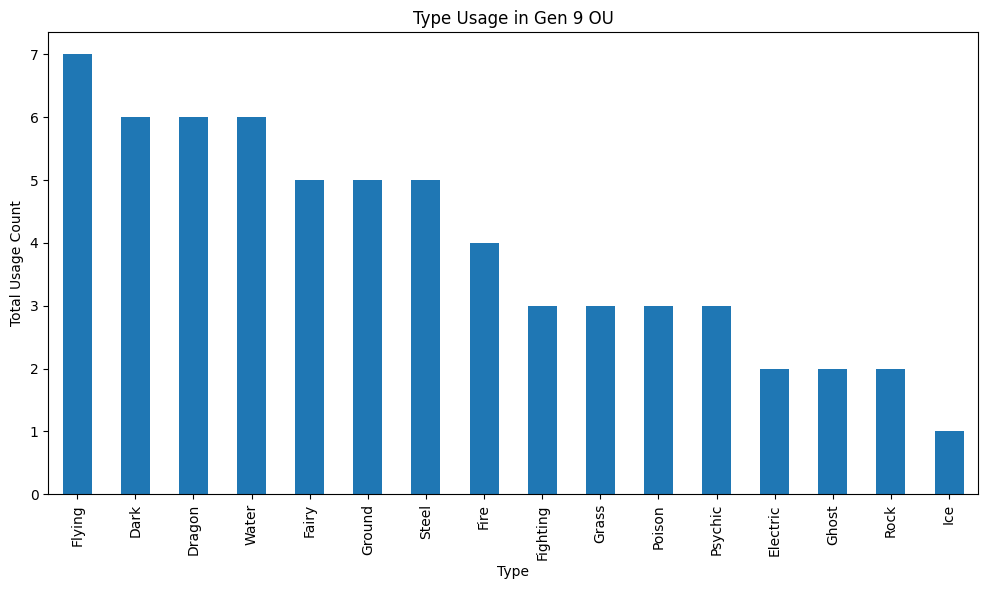

In [9]:
# Reading in the Dataset
gen9ou = read_pokemon_data('gen9', 'ou', '2024-11')

# Selecting only Pokemon with above 4.52% useage (the cutoff for actually being a OU Pokemon)
actual_gen9ou = gen9ou[gen9ou['Usage %'] >= 0.0452]

# Counting each type
type1_counts = actual_gen9ou['Type 1'].value_counts()
type2_counts = actual_gen9ou['Type 2'].value_counts()

# Combining the types into a single array
all_types = pd.concat([type1_counts, type2_counts])
type_counts = all_types.groupby(all_types.index).sum()
type_counts = type_counts.sort_values(ascending=False)

# Showing the plot
plt.figure(figsize=(12, 6))
type_counts.plot(kind='bar')
plt.title('Type Usage in Gen 9 OU')
plt.xlabel('Type')
plt.ylabel('Total Usage Count')

This graph is mostly just interesting to view the totals for each type and how they are distributed within the tier. I would love to go into way higher detail for this, but the most important thing to gather from this high useage rate of Flying Pokemon. This would lead you to assume that Tyranitar would be higher in useage, as rock types are super effective against Flying types. However, that model that I will be making will show something very different (which is the assumption I have from background knowledge of the king).

A second form of data visualization we can look at is (which is very important to our analysis) and this is the mean change in Pokemon base stat total over the generations. This is a very easy to graph, but a graph that has to be made iteratively as we will be looking at 9 different dataframes all combined into a single line graph!

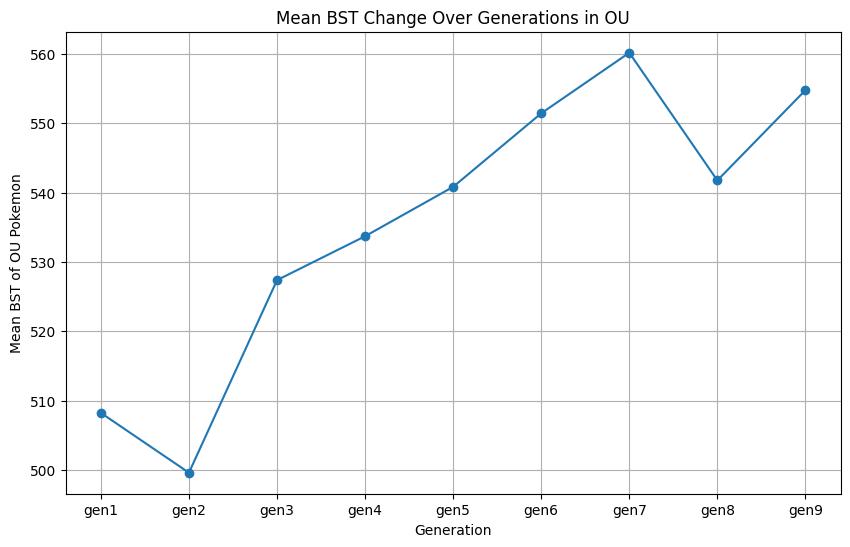

In [10]:
# Creating the generations for the input
generations = ['gen1', 'gen2', 'gen3', 'gen4', 'gen5', 'gen6', 'gen7', 'gen8', 'gen9']
bst_means = []

# Reading in each data file and saving mean BST
for gen in generations:
    df = read_pokemon_data(gen, 'ou', '2024-11')
    filtered_df = df[df['Usage %'] >= 0.0452]
    bst_means.append(np.mean(filtered_df['Total']))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(generations, bst_means, marker='o')
plt.xlabel('Generation')
plt.ylabel('Mean BST of OU Pokemon')
plt.title('Mean BST Change Over Generations in OU')
plt.grid(True)
plt.show()

We will analyze this graph on the fourth step, but for right now there is one more graph that I want to make and show. This is graph is very simply the current useage rate of Tyranitar since the start of the new generation (which begins at the period of 2022-11 and ends at 2024-11).

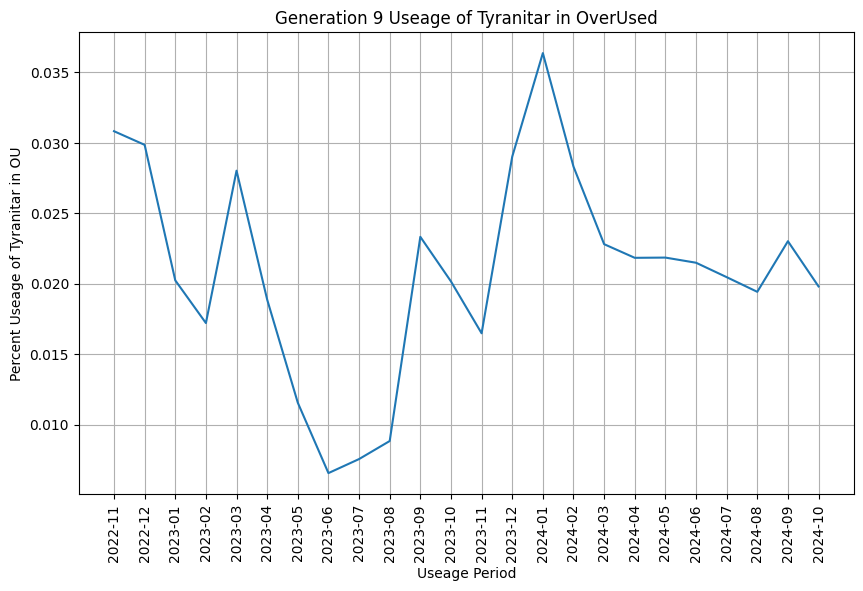

In [11]:
# Empty ttar set and starting the date count
ttar = []
years = []
year = 2022
month = 11

# This is reading the date period up until a certain point, and saving the Tyranitar useage for each point of data
while (f"{year}-{month}" != '2024-11'):
    years.append(f"{year}-{month}")
    df = read_pokemon_data('gen9', 'ou', f"{year}-{month}")
    ttar_usg = df.loc[df['Pokemon'] == 'Tyranitar', 'Usage %'].iloc[0]
    ttar.append(ttar_usg)
    month = int(month) + 1 # Adding one to month
    if month == 13: # If month is 13, we roll into next year
        month = 1
        year += 1
    if month != 10 or month != 11 or month != 12: # Adding the 0 to single digit months so the url works
        month = f"0{month}"
    if month == "010" or month == "011" or month == "012": # Removing the accidental 0 that gets added to 2 digit numbers
        month = int(month)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(years, ttar)
plt.xlabel('Useage Period')
plt.ylabel('Percent Useage of Tyranitar in OU')
plt.title('Generation 9 Useage of Tyranitar in OverUsed')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

This data is all over the place, but once again, I will be saving most of my analysis for the next portion of this project.

# 4. Analysis, Hypothesis Testing, and Machine Learning Model
Now it is time for the analysis that I have been putting off until this step, and connecting all of these different graphs and datasets together into one central concept (which the model will then be built off of).

Primarily, there is one thing to take note of, which is the fluctuation of Tyranitar's useage in this generation (ie. that final line graph). We also know that there is a general uptick in the average power level of Pokemon within OU. We know this by looking at the change in average BST across generations, which is the second graph. Tyranitar has really good base stats (20 points above the average for OU, at 600 opposed to the OU average of 580), but the creeping up of the average may be what is contributing to the decreasing useage of Tyranitar (at least in OU). I do also know that despite Tyranitar not loving his base typing, he doesn't want to tera as he loses his immunity to sandstorm,one of the things that makes Tyranitar as amazing as he is.

Now my theory is very simple, if we look at a previous generation (generation 8, which has a much larger sample size of data) we can get a general grasp on if Tyranitar's useage rate has actually been dipping across the years or if it is just a generation 9 thing. If we see a dip in his useage over gen 8, then we know it is not entirely localised to gen 9, and we can then possibly assume even less useage during gen 10, whenever that comes out.

To answer this question, I made a model (which uses data very similar to the third graph from the previous section) which uses linear regression to predict future values for Tyranitar's useage rate in generation 8, in comparison to all of the other Pokemon used in gen 8.

In [12]:
# Create an empty list to store DataFrames for each period
all_data = []
year = 2019
month = 11

# This is reading the date period up until a certain point, and then saving all the data into one big list
while (f"{year}-{month}" != '2024-11'):
    try:
        df = read_pokemon_data('gen8', 'ou', f"{year}-{month}")
        df = df[df['Usage %'] >= 0.025]
        df['Period'] = f"{year}-{month}"

        all_data.append(df)

    # In case of any particular data being missing
    except:
        pass

    month = int(month) + 1 # Adding one to month
    if month == 13: # If month is 13, we roll into next year
        month = 1
        year += 1
    if month != 10 or month != 11 or month != 12: # Adding the 0 to single digit months so the url works
        month = f"0{month}"
    if month == "010" or month == "011" or month == "012": # Removing the accidental 0 that gets added to 2 digit numbers
        month = int(month)

# Concatenate all DataFrames into a single part to turn into the model
gen8complete = pd.concat(all_data)
gen8complete.head()

,Pokemon,Usage %,RAW,RAW %,REAL,REAL %,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Period
Rank,,,,,,,,,,,,,,,,
1,Dragapult,0.362202,921374,0.35663,660270,0.34170,Dragon,Ghost,600.0,88.0,120.0,75.0,100.0,75.0,142.0,2019-11
2,Darmanitan-Galar,0.338669,845528,0.32727,639910,0.33117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11
3,Excadrill,0.273393,647707,0.25070,503401,0.26052,Ground,Steel,508.0,110.0,135.0,60.0,50.0,65.0,88.0,2019-11
4,Corviknight,0.248742,624516,0.24173,464274,0.24027,Flying,Steel,495.0,98.0,87.0,105.0,53.0,85.0,67.0,2019-11
5,Ferrothorn,0.248740,601620,0.23286,499486,0.25849,Grass,Steel,489.0,74.0,94.0,131.0,54.0,116.0,20.0,2019-11


There is the data set that we will be using for making and training our regression model, and we will be generally looking into predicting the useage rate for Tyranitar 12 months from now.

In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# Define the features.
features = ['Pokemon', 'Period']

# Define the training data.
# Represent the features as a list of dicts.
X_train_dict = gen8complete[features].to_dict(orient="records")
X_new_dict = [{
      "Pokemon" : 'Tyranitar',
      "Period" : '2026-01'
}]
y_train = gen8complete["Usage %"]

# Dummy encoding
vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)
X_new = vec.transform(X_new_dict)

# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_new_sc = scaler.transform(X_new)

# K-Nearest Neighbors Model
model = KNeighborsRegressor(n_neighbors=30)
model.fit(X_train_sc, y_train)
model.predict(X_new_sc)

array([0.08413993])

And just like that, our model predicts that Tyranitar will have a usage rate of 8.4% by the end of January 2026 (a little over a year from now). We can also use this model to predict the usage rate of any Pokemon in gen 8 OU for any time in the future, which is great! Now onto my conclusory analysis and ending thoughts.

# 5. Insight and Policy Decision

My model was generally pretty simply, and I acknowledge that, it's just because the data I'm dealing with is very limited in it's scope there are only so many options I have available to me for prediction. Assumptions that my model makes is that there won't be a ban for any other Pokemon any time soon, but since my model is based on a past gen, there usually are not bans for generations of Pokemon that have already ended.

In conclusion, Tyranitar is decreasing in useage in generation 8, and I after looking at the graph of generation 9 ou usage, it almost lines up exactly with the fluctuations in the generation 8 graph that I generated on the side (I felt no need to include it as it is almost the same exact graph, with just a year more of data collected). The final model that I made to predict any useage rate is interesting though, and is a side effect of predicting Tyranitar that I did not necessarily expect.

There are no policies I can really suggest, as competetive Pokemon is not a governing body and is more just a community of friends who play a really fun video game together (on a fanmade website). If anything, I can say that Tyranitar is likely to decrease in useage by next year, so maybe plan for that when you are building your teams?

In the grand scheme of things, some random Pokemon's (the King of OU to few) usage rate in a video game meant for children does not matter in the world. At least on first though. But over the course of this small little project, I aim to hopefully make DataScience more available and open to people who have maybe no interest in DataScience, but would like to know more about Pokemon. This project was super easy to make with that idea, the idea of spreading DataScience to others and specifically Pokemon fans. I have already been keeping some of my friends updated with what I have been doing (all of the Milestones) and they have genuinely been really interested in what the next step in the Data Cycle is, which is a complete success to me.



---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%shell
!jupyter nbconvert --to html /content/jacob_deliverable2.ipynb

[NbConvertApp] Converting notebook /content/jacob_milestone2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 680277 bytes to /content/jacob_milestone2.html
